In [1]:
import pandas as pd
from os import listdir
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Create dataframe with all Data (except end)
n = 0 # counter to grab only first header
m = 6 # number of months to grab from (usually 6)
months = [x + "month" for x in map(str, range(1, 1 + m))]
for dir in listdir("Data/"):
    if dir in months:
        for file in listdir("Data/" + dir):
            try: 
                dfa = pd.read_excel("Data/" + dir + "/" + file, sheet_name = 1)
                n += 1
                header = dfa.iloc[0]
                if n == 1:
                    df = pd.DataFrame(columns = header)
                dfa = dfa[1:]
                dfa.columns = header
                df = pd.concat([dfa, df])
            except ValueError: # so non-excel files aren't grabbed
                pass

In [3]:
df

,Rk,Name,Team,Age,Pos,GP,G,A,P,PIM,...,G/GP,A/GP,P/GP,SHOTS,SH%,HITS,BS,FOW,FOL,FO%
1,1,Connor McDavid,EDM,25,F,79,62,86,148,36,...,0.785,1.089,1.873,334,18.6%,89,39,511,473,51.93%
2,2,Leon Draisaitl,EDM,27,F,77,51,72,123,24,...,0.662,0.935,1.597,243,21.0%,64,40,781,642,54.88%
3,3,Nikita Kucherov,TBL,29,F,79,30,78,108,34,...,0.38,0.987,1.367,256,11.7%,58,28,2,0,100.00%
4,4,Matthew Tkachuk,FLA,25,F,76,39,66,105,109,...,0.513,0.868,1.382,304,12.8%,63,31,13,16,44.83%
5,5,David Pastrnak,BOS,26,F,78,57,47,104,36,...,0.731,0.603,1.333,379,15.0%,87,33,8,11,42.11%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,985,Ville Husso,DET,27,G,46,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
986,986,Juuse Saros,NSH,27,G,47,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
987,987,Carter Hart,PHI,24,G,47,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
988,988,Ilya Sorokin,NYI,27,G,48,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Remove goalie entries
df = df[df.Pos != "G"]
# Remove unnecessary columns
df = df.drop(['Rk','Team'], axis=1)

# Convert time stats (e.g., 20:12) to seconds.
# Define function that does the string conversion:
def time2sec(time):
    m, s = time.split(':')
    return 60 * int(m) + int(s)

df['TOI'] = df['TOI'].apply(time2sec) 
df['ES'] = df['ES'].apply(time2sec) 
df['PP'] = df['PP'].apply(time2sec) 
df['SH'] = df['SH'].apply(time2sec) 

# Convert Position to boolean (0 = D, 1 = F)
def Pos2bool(pos):
    if pos == "D":
        return 0
    if pos == "F":
        return 1
        
df['Pos'] = df['Pos'].apply(Pos2bool)

# Remove '%' symbol from columns
def perc_rem(string):
    return string.replace('%','')

df['PPP%'] = df['PPP%'].apply(perc_rem)
df['FO%'] = df['FO%'].apply(perc_rem)
df['SH%'] = df['SH%'].apply(perc_rem)

In [5]:
# Create dataframe with season-end Data
m = 0 # counter to grab only first header
for file in listdir("Data/end/"):
    try: 
        dfa = pd.read_excel("Data/end/" + file, sheet_name = 1)
        m += 1
        header = dfa.iloc[0]
        if m == 1:
            dfend = pd.DataFrame(columns = header)
        dfa = dfa[1:]
        dfa.columns = header
        dfend = pd.concat([dfa, dfend])
    except ValueError: # so non-excel files aren't grabbed
        pass

In [6]:
# Keep only name (and age for matching) and points total
dfend = dfend[['Name', 'Age', 'P']]
dfend = dfend.rename(columns={'P': 'Pend'})

In [7]:
dfend

,Name,Age,Pend
1,Kyle Palmieri,31,33
2,Kevin Labanc,27,33
3,Anton Lundell,21,33
4,Sonny Milano,26,33
5,John Klingberg,30,33
...,...,...,...
46,Viktor Arvidsson,29,59
47,Roman Josi,32,59
48,Casey Mittelstadt,24,59
49,Patrice Bergeron,37,58


In [8]:
#Join all data and season end data
df = pd.merge(df, dfend, on=['Name', 'Age'], how='left')
#Remove rows where Pend is less than 10
df = df[df.Pend > 9]
# Convert all data to numerical values
for col in list(df.columns):
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        pass

In [9]:
df["Name_GP"] = df.Name + "_" + df.GP.astype(str)
df = df.set_index('Name_GP')

del df["Name"]

# Split Data

In [10]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)

In [11]:
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [12]:
y_train = df_train.Pend
y_val = df_val.Pend
y_test = df_test.Pend

del df_train['Pend']
del df_val['Pend']
del df_test['Pend']

In [ ]:
base = list(df_train.columns)

In [25]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [26]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)
X_test = prepare_X(df_test)

# Linear Regression

In [20]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [23]:
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.01)
y_train_pred = w_0 + X_train.dot(w)

y_val_pred = w_0 + X_val.dot(w)

## Evaluate Accuracy

In [27]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

def mae(y, y_pred):
    error = abs(y_pred - y)
    return error.mean()

In [28]:
print('train:', '\n rmse =', rmse(y_train, y_train_pred), '\n mae = ', mae(y_train, y_train_pred))
print('validation:', '\n rmse =', rmse(y_val, y_val_pred), '\n mae = ', mae(y_val, y_val_pred))

train: 
 rmse = 8.065358123474535 
 mae =  5.9228786993673515
validation: 
 rmse = 8.887497921718596 
 mae =  6.521815901573227


# Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
scores = []
scorebest = 10**6
for e in range(100,200,10):
    print(e)
    rf = RandomForestRegressor(n_estimators=e, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_train_pred_rf = rf.predict(X_train)
    y_val_pred_rf = rf.predict(X_val)
    score_e = rmse(y_val, y_val_pred_rf)
    scores.append([e,score_e])
    if score_e < scorebest:
        scorebest = score_e
        ebest = e

100
110
120
130
140
150
160
170


KeyboardInterrupt: 

In [ ]:
dfscores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

In [ ]:
plt.plot(dfscores.n_estimators, dfscores.rmse)

In [ ]:
ebest

In [ ]:
scores = []

for d in [15, 20, 25]:
    print(d)
    for n in range(100,160,20):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = rmse(y_val, y_pred)

        scores.append((d, n, score))

In [ ]:
columns = ['max_depth', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
for d in [15,20,25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.score,
             label='max_depth=%d' % d)

plt.legend()

In [ ]:
max_depth = 20

In [ ]:
scores = []

for s in [1, 3, 5, 10, 50]:
    print(s)
    for n in range(120, 220, 20):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = rmse(y_val, y_pred)

        scores.append((s, n, score))

In [ ]:
columns = ['min_samples_leaf', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
values = [1, 3, 5, 10, 50]

for s in values:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.score,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [ ]:
min_samples_leaf = 1

In [ ]:
rf = RandomForestRegressor(n_estimators=120,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

In [ ]:
y_val_pred_rf = rf.predict(X_val)
print('validation:', '\n rmse =', rmse(y_val, y_val_pred_rf), '\n mae = ', mae(y_val, y_val_pred_rf))

In [ ]:
X_test = prepare_X(df_test)
y_test_pred_rf = rf.predict(X_test)
print('test:', '\n rmse =', rmse(y_test, y_test_pred_rf), '\n mae = ', mae(y_test, y_test_pred_rf))

# Testing on Data just 1 month in again

This model appears to perform much better! However, it's deceiving because this dataset includes data close to the end of season, which is easier to predict. Let's see how the model does just on the 1 month data:

In [ ]:
df_1month = pd.concat([df_test[df_test.GP < 14], df_val[df_val.GP < 14]])

In [ ]:
df_y_test = pd.DataFrame(y_test)
df_y_val = pd.DataFrame(y_val)
df_y_1month = pd.concat([df_y_test, df_y_val])
df_y_1month = df_y_1month.reset_index()
df_y_1month[['Name', 'GP']] = df_y_1month['Name_GP'].str.split('_', expand=True)
df_y_1month["GP"] = pd.to_numeric(df_y_1month["GP"])
df_y_1month = df_y_1month[df_y_1month.GP < 14]
df_y_1month = df_y_1month.set_index("Name_GP")

y_1month = df_y_1month["Pend"]

In [ ]:
X_1month = prepare_X(df_1month)
y_1month_pred = w_0 + X_1month.dot(w)
y_1month_pred_rf = rf.predict(X_1month)
print('Linear Regression:', '\n rmse =', rmse(y_1month, y_1month_pred), '\n mae = ', mae(y_1month, y_1month_pred))
print('Random Forest:', '\n rmse =', rmse(y_1month, y_1month_pred_rf), '\n mae = ', mae(y_1month, y_1month_pred_rf))

### Actually not too bad!

In [ ]:
def maxdif(y, y_pred):
    error = abs(y - y_pred)
    error_sorted = error.sort_values(ascending=False)[:5]
    return error_sorted

In [ ]:
print('Linear Regression:', '\n 5 Largest Residuals \n', maxdif(y_1month, y_1month_pred))
print('Random Forest:', '\n 5 Largest Residuals \n', maxdif(y_1month, y_1month_pred_rf))

## Investigating Random Forest

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import export_text

tree_index = 25
individual_tree = rf.estimators_[tree_index]

# Plot the first decision tree in the random forest
plt.figure(figsize=(20, 10))
plot_tree(individual_tree, max_depth=2, label='root', filled=True, feature_names=list(df_train.columns), class_names=True)
plt.show()

In [ ]:
rf.feature_importances_
importances = list(zip(list(df_train.columns), rf.feature_importances_))

df_importance = pd.DataFrame(importances, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)

df_importance

# Compare models to simple extrapolation

In [ ]:
df_test_simp = df_test.copy()
df_test_simp["Pred"] = 82 * df_test_simp["P/GP"]
y_test_simp = df_test_simp["Pred"]

In [ ]:
print('Simple Model:', '\n rmse =', rmse(y_test, y_test_simp), '\n mae = ', mae(y_test, y_test_simp))
print('Linear Regression:', '\n rmse =', rmse(y_test, y_test_pred), '\n mae = ', mae(y_test, y_test_pred))
print('Random Forest:', '\n rmse =', rmse(y_test, y_test_pred_rf), '\n mae = ', mae(y_test, y_test_pred_rf))

### Thus, our models are certainly better than the simple model. The simple model does fail terribly for very low GPs, as expected:

In [ ]:
print('Simple model:', '\n 5 Largest Residuals \n', maxdif(y_test, y_test_simp))

# Gradient Boosting

In [31]:
import xgboost as xgb

In [32]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(df_train.columns))
dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(df_train.columns))
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(df_train.columns))

In [38]:
X_test

array([[ 38.  ,   1.  ,  78.  , ..., 348.  , 307.  ,  53.13],
       [ 28.  ,   0.  ,  46.  , ...,   0.  ,   0.  ,   0.  ],
       [ 27.  ,   1.  ,  62.  , ...,   1.  ,   5.  ,  16.67],
       ...,
       [ 31.  ,   1.  ,   5.  , ...,  18.  ,  15.  ,  54.55],
       [ 30.  ,   1.  ,  42.  , ..., 293.  , 240.  ,  54.97],
       [ 28.  ,   1.  ,  25.  , ..., 177.  , 144.  ,  55.14]])

In [671]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,  
}

gb = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [672]:
y_val_pred_gb = gb.predict(dval)
y_test_pred_gb = gb.predict(dtest)

In [673]:
print('\n rmse =', rmse(y_val, y_val_pred_gb), '\n mae = ', mae(y_val, y_val_pred_gb))


 rmse = 6.903487049852391 
 mae =  4.738119786126273


In [33]:
watchlist = [(dtrain, "train"), (dval, "val")]

In [584]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,  
}

gb = xgb.train(xgb_params, dtrain, num_boost_round=5000, verbose_eval = 1, evals = watchlist)

In [675]:
def parse_xgb_output(output):
    tree = []
    rmse_train = []
    rmse_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        rmse_train.append(train)
        rmse_val.append(val)

    return tree, rmse_train, rmse_val

In [520]:
tree, rmse_train, rmse_val = parse_xgb_output(output)

## Checking how num_boost_round affects results

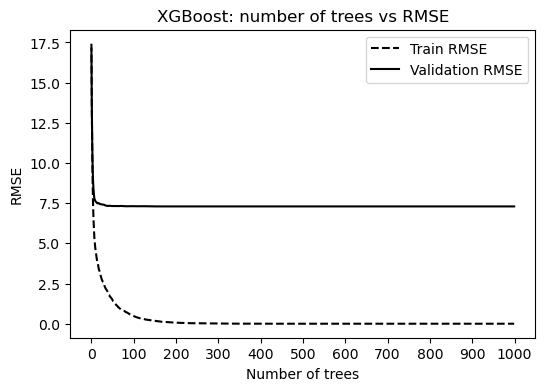

In [583]:


plt.figure(figsize=(6, 4))

plt.plot(tree, rmse_train, color='black', linestyle='dashed', label='Train RMSE')
plt.plot(tree, rmse_val, color='black', linestyle='solid', label='Validation RMSE')
plt.xticks(range(0, 1001, 100))

plt.legend()

plt.title('XGBoost: number of trees vs RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')

plt.show()



## Checking how eta affects results

In [585]:
tree, _, rmse_val_eta_03 = parse_xgb_output(output)
print(min(rmse_val_eta_03))
print(min(zip(rmse_val_eta_03, tree)))

7.29642
(7.29642, 189)


In [586]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,  
}

gb = xgb.train(xgb_params, dtrain, num_boost_round=5000, verbose_eval = 1, evals = watchlist)

In [587]:
tree, _, rmse_val_eta_01 = parse_xgb_output(output)
print(min(rmse_val_eta_01))
print(min(zip(rmse_val_eta_01, tree)))

6.87328
(6.87328, 1107)


In [588]:
%%capture output

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,  
}

gb = xgb.train(xgb_params, dtrain, num_boost_round=5000, verbose_eval = 1, evals = watchlist)

In [589]:
tree, _, rmse_val_eta_005 = parse_xgb_output(output)
print(min(rmse_val_eta_005))
print(min(zip(rmse_val_eta_005, tree)))

6.78022
(6.78022, 1505)


In [590]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,  
}

gb = xgb.train(xgb_params, dtrain, num_boost_round=5000, verbose_eval = 1, evals = watchlist)

In [591]:
tree, _, rmse_val_eta_001 = parse_xgb_output(output)
print(min(rmse_val_eta_001))
print(min(zip(rmse_val_eta_001, tree)))

6.74886
(6.74886, 4993)


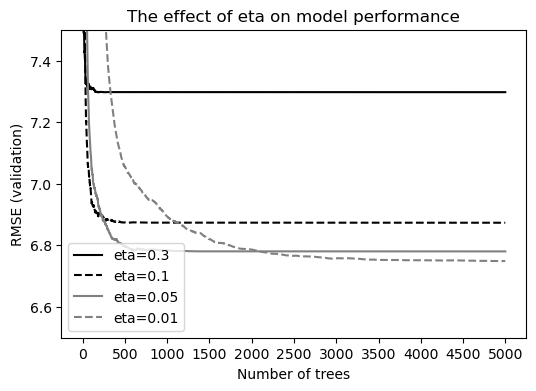

In [595]:
plt.figure(figsize=(6, 4))

plt.plot(tree, rmse_val_eta_03, color='black', linestyle='solid', label='eta=0.3')
plt.plot(tree, rmse_val_eta_01, color='black', linestyle='dashed', label='eta=0.1')
plt.plot(tree, rmse_val_eta_005, color='grey', linestyle='solid', label='eta=0.05')
plt.plot(tree, rmse_val_eta_001, color='grey', linestyle='dashed', label='eta=0.01')

plt.xticks(range(0, 5001, 500))
plt.ylim(6.5, 7.5)

plt.legend()

plt.title('The effect of eta on model performance')
plt.xlabel('Number of trees')
plt.ylabel('RMSE (validation)')


plt.show()

## Checking how max_depth affects results

In [621]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 7,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,  
}

gb = xgb.train(xgb_params, dtrain, num_boost_round=5000, verbose_eval = 1, evals = watchlist)

In [623]:
tree, _, rmse_val_depth7 = parse_xgb_output(output)
print(min(rmse_val_depth7))
print(min(zip(rmse_val_depth7, tree)))

6.90547
(6.90547, 4990)


In [602]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 4,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,  
}

gb = xgb.train(xgb_params, dtrain, num_boost_round=5000, verbose_eval = 1, evals = watchlist)

In [603]:
tree, _, rmse_val_depth4 = parse_xgb_output(output)
print(min(rmse_val_depth4))
print(min(zip(rmse_val_depth4, tree)))

6.82506
(6.82506, 4999)


In [604]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 5,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,  
}

gb = xgb.train(xgb_params, dtrain, num_boost_round=5000, verbose_eval = 1, evals = watchlist)

In [605]:
tree, _, rmse_val_depth5 = parse_xgb_output(output)
print(min(rmse_val_depth5))
print(min(zip(rmse_val_depth5, tree)))

6.83692
(6.83692, 4769)


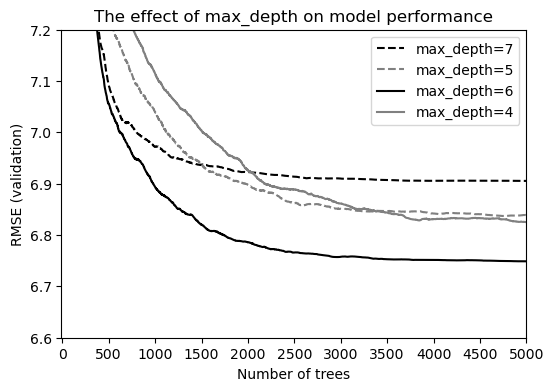

In [624]:
plt.figure(figsize=(6, 4))

plt.plot(tree, rmse_val_depth7, color='black', linestyle='dashed', label='max_depth=7')
plt.plot(tree, rmse_val_depth5, color='grey', linestyle='dashed', label='max_depth=5')
plt.plot(tree, rmse_val_eta_001, color='black', linestyle='solid', label='max_depth=6')
plt.plot(tree, rmse_val_depth4, color='grey', linestyle='solid', label='max_depth=4')

plt.ylim(6.6, 7.2)
plt.xlim(-10, 510)
plt.xticks(range(0, 5001, 500))

plt.legend()

plt.title('The effect of max_depth on model performance')
plt.xlabel('Number of trees')
plt.ylabel('RMSE (validation)')


plt.show()

## Tune min_child_weight

In [619]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,  
}

gb = xgb.train(xgb_params, dtrain, num_boost_round=5000, verbose_eval = 1, evals = watchlist)

In [620]:
tree, _, rmse_val_mcw1 = parse_xgb_output(output)
print(min(rmse_val_mcw1))
print(min(zip(rmse_val_mcw1, tree)))

6.74886
(6.74886, 4993)


In [635]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 5,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,  
}

gb = xgb.train(xgb_params, dtrain, num_boost_round=5000, verbose_eval = 1, evals = watchlist)

In [636]:
tree, _, rmse_val_mcw5 = parse_xgb_output(output)
print(min(rmse_val_mcw5))
print(min(zip(rmse_val_mcw5, tree)))

6.78341
(6.78341, 4862)


In [638]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 3,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,  
}

gb = xgb.train(xgb_params, dtrain, num_boost_round=5000, verbose_eval = 1, evals = watchlist)

In [639]:
tree, _, rmse_val_mcw3 = parse_xgb_output(output)
print(min(rmse_val_mcw3))
print(min(zip(rmse_val_mcw3, tree)))

6.85669
(6.85669, 3006)


In [645]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 6,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,  
}

gb = xgb.train(xgb_params, dtrain, num_boost_round=5000, verbose_eval = 1, evals = watchlist)

In [646]:
tree, _, rmse_val_mcw6 = parse_xgb_output(output)
print(min(rmse_val_mcw6))
print(min(zip(rmse_val_mcw6, tree)))

6.84478
(6.84478, 4523)


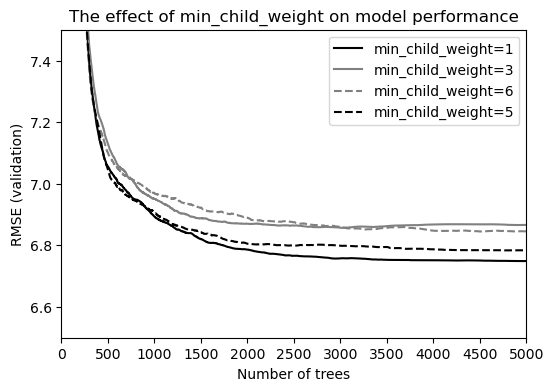

In [647]:
plt.figure(figsize=(6, 4))

plt.plot(tree, rmse_val_mcw1, color='black', linestyle='solid', label='min_child_weight=1')
plt.plot(tree, rmse_val_mcw3, color='grey', linestyle='solid', label='min_child_weight=3')
plt.plot(tree, rmse_val_mcw6, color='grey', linestyle='dashed', label='min_child_weight=6')
plt.plot(tree, rmse_val_mcw5, color='black', linestyle='dashed', label='min_child_weight=5')

plt.ylim(6.5, 7.5)
plt.xlim(0, 5001)
plt.xticks(range(0, 5001, 500))

plt.legend()

plt.title('The effect of min_child_weight on model performance')
plt.xlabel('Number of trees')
plt.ylabel('RMSE (validation)')

plt.show()

## Final Gradient Boost Model

In [34]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,  
}

gb = xgb.train(xgb_params, dtrain, num_boost_round=10000, verbose_eval = 1, evals = watchlist)

In [35]:
gb.save_model('model1')

/Users/riley/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:40:08] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [690]:
y_val_pred_gb = gb.predict(dval)
y_test_pred_gb = gb.predict(dtest)

In [691]:
print('Gradient Boosting:', '\n rmse =', rmse(y_val, y_val_pred_gb), '\n mae = ', mae(y_val, y_val_pred_gb))
print('Gradient Boosting:', '\n 5 Largest Residuals \n', maxdif(y_test, y_test_pred_gb))

Gradient Boosting: 
 rmse = 6.744598740205384 
 mae =  4.534530933925084
Gradient Boosting: 
 5 Largest Residuals 
 Name_GP
Jared McCann_11        27.925919
Connor McDavid_13      27.681320
Jordan Greenway_1      27.204491
Robby Fabbri_13        27.106129
Carter Verhaeghe_13    25.577271
Name: Pend, dtype: float64


### Comparison to all previous models:

In [692]:
print('Simple Model:', '\n rmse =', rmse(y_test, y_test_simp), '\n mae = ', mae(y_test, y_test_simp))
print('Linear Regression:', '\n rmse =', rmse(y_test, y_test_pred), '\n mae = ', mae(y_test, y_test_pred))
print('Random Forest:', '\n rmse =', rmse(y_test, y_test_pred_rf), '\n mae = ', mae(y_test, y_test_pred_rf))
print('Gradient Boosting:', '\n rmse =', rmse(y_test, y_test_pred_gb), '\n mae = ', mae(y_test, y_test_pred_gb))

Simple Model: 
 rmse = 12.74979458344329 
 mae =  8.459039999999991
Linear Regression: 
 rmse = 7.888248219171965 
 mae =  5.796840050053834
Random Forest: 
 rmse = 6.760429713877552 
 mae =  4.629697431231239
Gradient Boosting: 
 rmse = 6.520630288468742 
 mae =  4.440309012276786


In [693]:
d1month = xgb.DMatrix(X_1month, label=y_1month, feature_names=list(df_train.columns))
y_1month_pred_gb = gb.predict(d1month)

In [694]:
print('Linear Regression:', '\n rmse =', rmse(y_1month, y_1month_pred), '\n mae = ', mae(y_1month, y_1month_pred))
print('Random Forest:', '\n rmse =', rmse(y_1month, y_1month_pred_rf), '\n mae = ', mae(y_1month, y_1month_pred_rf))
print('Random Forest:', '\n rmse =', rmse(y_1month, y_1month_pred_rf), '\n mae = ', mae(y_1month, y_1month_pred_rf))
print('Gradient Boosting:', '\n rmse =', rmse(y_1month, y_1month_pred_gb), '\n mae = ', mae(y_1month, y_1month_pred_gb))

Linear Regression: 
 rmse = 11.452405387658153 
 mae =  8.654972088659294
Random Forest: 
 rmse = 10.738282561631896 
 mae =  7.870281719450968
Random Forest: 
 rmse = 10.738282561631896 
 mae =  7.870281719450968
Gradient Boosting: 
 rmse = 10.152375259951365 
 mae =  7.410340933706246


## Investigating gradient boost model

In [683]:
scores = gb.get_score(importance_type='gain')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('P/GP', 5392.1142578125),
 ('PPA', 294.6878662109375),
 ('PP', 158.92091369628906),
 ('PPP', 135.18714904785156),
 ('P', 105.9485092163086),
 ('TOI', 62.361785888671875),
 ('SHOTS', 54.06369400024414),
 ('PPP%', 48.56553649902344),
 ('GWP', 46.08100128173828),
 ('GWA', 42.155601501464844),
 ('ESG', 39.96381759643555),
 ('FOL', 38.5832633972168),
 ('A/60', 38.27329635620117),
 ('FO%', 36.86013412475586),
 ('SHG', 34.827030181884766),
 ('PPP/60', 31.288352966308594),
 ('PPA/60', 29.91207504272461),
 ('PPG/60', 29.90788459777832),
 ('ES', 29.094818115234375),
 ('OTG', 28.811786651611328),
 ('PPG', 27.631406784057617),
 ('SHP', 26.227025985717773),
 ('ESA', 24.414573669433594),
 ('FOW', 24.075525283813477),
 ('ESP', 23.60276222229004),
 ('G/GP', 23.299623489379883),
 ('OTA', 22.515684127807617),
 ('P/60', 21.235294342041016),
 ('SH', 20.72019386291504),
 ('A/GP', 19.805612564086914),
 ('SH%', 19.43706512451172),
 ('HITS', 19.358549118041992),
 ('BS', 18.5933780670166),
 ('ESP/60', 18.215

In [684]:
names = [n for (n, s) in scores]
scores = [s for (n, s) in scores]

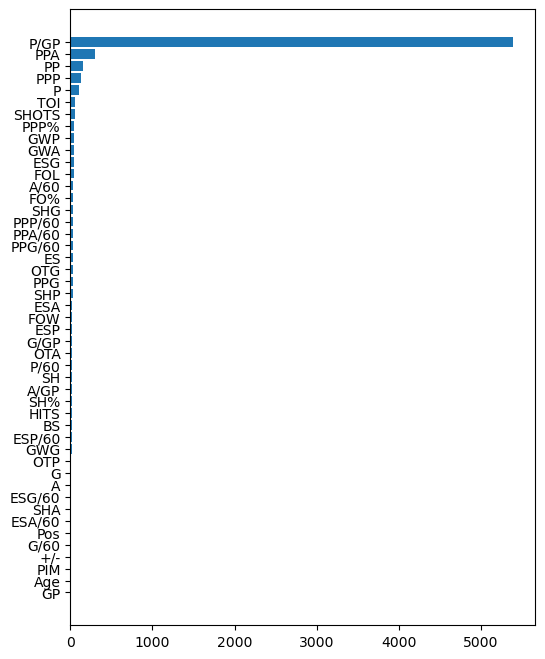

In [685]:
plt.figure(figsize=(6, 8))

plt.barh(np.arange(len(scores)), scores)
plt.yticks(np.arange(len(names)), names)

plt.show()

# Neural Network

In [715]:
def multiplier(m):
    return lambda a: a*m

In [716]:
doubler = multiplier(2)

In [717]:
doubler(2)

4

In [720]:
array = np.random.rand(5, 1)

In [721]:
array

array([[0.54071993],
       [0.24001689],
       [0.06484607],
       [0.56212869],
       [0.34025901]])